# Visibilities
An overview of the visibility data structure and manipulation.

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/visibilities.ipynb)

test

In [1]:
# Installation  
import os
print("installing casa6 + cngi (takes a minute or two)...")
os.system("apt-get install libgfortran3")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.1.0.118")
#os.system("pip install cngi-prototype==0.0.57")
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.66rc10")

# Retrieve and extract demonstration dataset
print('retrieving MS tarfiles...')
!gdown -q --id 15HfB4rJKqEH7df088Ge5YLrCTXBIax6R
!gdown -q --id 1N9QSs2Hbhi-BrEHx5PA54WigXt8GGgx1
print('extracting MS tarfiles...')
!tar -xf M100.ms.tar
!tar -xzf sis14_twhya_calibrated_flagged.ms.tar.gz

print('complete')

installing casa6 + cngi (takes a minute or two)...
retrieving MS tarfiles...
extracting MS tarfiles...
complete


## Initialize the Environment
`InitializeFramework` instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.  

```python
>>> from cngi.direct import InitializeFramework
>>> client = InitializeFramework(workers=4, memory='2GB')
>>> print(client)
<Client: 'tcp://127.0.0.1:33227' processes=4 threads=4, memory=8.00 GB>
```

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

Google Colab doesn't really support the dask.distributed environment particularly well, so we will let Dask use its default scheduler.


## MeasurementSet Conversion
CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) dataset and the zarr storage format to hold the contents of the MS.  This provides several advantages to the old MS structure including:
1. Easier access and manipulation of data with numpy-like mathematics
2. N-dim visibility cubes (time, baseline, chan, pol) instead of interlaced rows of variable shape
3. Natively parallel and scalable operations


### Data Description IDs

The conversion process will translate an MS directory on disk into one or more Xarray Datasets (xds) and (optionally) store them to a Zarr directory on disk.  To properly support dimension expansion from interlaced rows, each MS SPW/Pol combination, denoted by Data Description ID (**DDI**), must be processed and partitioned individually, along with the various subtables.

We begin by inspecting the structure of the M100 MeasurementSet to determine how best to convert it

In [2]:
from cngi.conversion import describe_ms

describe_ms('M100.ms')

,spw_id,pol_id,rows,times,baselines,chans,pols,size_MB
ddi,,,,,,,,
0,0,0,32464,568,154,240,2,681
1,1,0,32464,568,154,240,2,681
2,2,0,32464,568,154,240,2,681
3,3,0,31408,568,142,240,2,628


This demonstration MS has four DDI's, corresponding to four different SPW's. In this case they are of similar modest size.

Let's convert two of them now using the default settings

In [3]:
from cngi.conversion import convert_ms

mxds = convert_ms('M100.ms', ddis=[0,2])

Completed ddi 0  process time 9.50 s
Completed ddi 2  process time 9.09 s
                                                  


Larger numbers of baselines and channels will consume more memory during conversion. If a particular DDI shape is too large for the host machine memory, a smaller chunk size along the time axis may be needed.

Let's pretend this is the case for the other two DDI's and use a smaller chunk size for them, making sure to append and not overwrite our first two

In [4]:
mxds = convert_ms('M100.ms', ddis=[1,3], chunk_shape=(50,400,32,1), append=True)

Completed ddi 1  process time 11.85 s
Completed ddi 3  process time 12.23 s
                                                  


Finally, lets get the subtables within the original MS. They are now referred to as the "global" data in Zarr directory as their contents applies to all of the DDI partitions.

Some subtable columns may give errors during conversion if the casacore table system cannot read them as numpy arrays. The resulting Xarray dataset will omit these columns.  *This is a known issue*

In [5]:
mxds = convert_ms('M100.ms', ddis=['global'], append=True)

Completed subtables  process time 0.89 s
                                                  


If we are comfortable with leaving things at default, we can convert the entire contents of an MS at once. The TWHya MS is small and safe to convert without much worry, but we will give it a shorter output filename.


In [6]:
from cngi.conversion import convert_ms

mxds = convert_ms('sis14_twhya_calibrated_flagged.ms', outfile='twhya.vis.zarr')

Completed ddi 0  process time 23.89 s
Completed subtables  process time 1.28 s
                                                  


### Xarray/Zarr Partitions

After converting an MS to the new Xarray / Zarr based format, we have a ```<filename>.vis.zarr``` directory on disk.  We can inspect its contents to see if the conversion was successful. 

In [7]:
from cngi.dio import describe_vis

describe_vis('M100.vis.zarr')

,spw_id,pol_id,times,baselines,chans,pols,size_MB
xds,,,,,,,
xds0,0,0,568,154,240,2,1009
xds1,1,0,568,154,240,2,1009
xds2,2,0,568,154,240,2,1009
xds3,3,0,568,142,240,2,930


The four SPW's are now contained in four separate partitions.  There are no more rows, only the four dimensions of (time, baseline, channel, polarization) to describe each field.

When we go to open and use the new format for subsequent CNGI operations, we will refer to the specific visibility xarray dataset (**xds**) that we want to use.

### MeasurementSet v3 Schema

The conversion process attempts to keep the same column names, definitions, and relationships from the original MS structure whenever possible.  This means that, for example, the DATA column of the main table in the MS is still called DATA in the Xarray Dataset, but it is now a data variable within the dataset.  Similarly the column names of the various subtables are reflected as data variable names in the new xarray datasets.

As part of the evolution to new datastructures, the opportunity was taken to also update to the new MSv3 schema.  This means that when converting the current CASA MSv2 datasets, certain columns are translated or dropped per the MSv3 definition located [here](https://drive.google.com/file/d/10TZ4dsFw9CconBc-GFxSeb2caT6wkmza/view?usp=sharing).

While CNGI typically only operates on a single visibility partition, we can open and inspect the entire zarr directory contents in a manner similar to how the entire MS could be opened and inspected previously.  This is done by constructing an xarray *dataset of datasets*, referred to as the master xarray dataset (**mxds**).

In [8]:
from cngi.dio import read_vis

mxds = read_vis('M100.vis.zarr')

print(mxds)

<xarray.Dataset>
Dimensions:           (antenna_ids: 27, feed_ids: 108, field_ids: 48, observation_ids: 4, polarization_ids: 1, source_ids: 4, spw_ids: 4, state_ids: 24)
Coordinates:
  * antenna_ids       (antenna_ids) int64 0 1 2 3 4 5 6 ... 20 21 22 23 24 25 26
    antennas          (antenna_ids) <U16 'CM01' 'DV01' 'DV03' ... 'PM01' 'PM03'
  * field_ids         (field_ids) int64 0 1 2 3 4 5 6 7 ... 41 42 43 44 45 46 47
    fields            (field_ids) <U16 'M100' 'M100' 'M100' ... 'M100' 'M100'
  * feed_ids          (feed_ids) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * observation_ids   (observation_ids) int64 0 1 2 3
    observations      (observation_ids) <U16 'T.B.D.' 'T.B.D.' 'T.B.D.' 'T.B.D.'
  * polarization_ids  (polarization_ids) int64 0
  * source_ids        (source_ids) int32 0 0 0 0
    sources           (source_ids) <U16 'M100' 'M100' 'M100' 'M100'
  * spw_ids           (spw_ids) int64 0 1 2 3
  * state_ids         (state_ids) int64 0 1 2 3 4 5 6 7 ... 17 18 19 

The mxds **coordinates** describe the principal keys to different tables in the MSv3 schema. The **attributes** section holds references to each individual xarray dataset visibility partition and subtable of global data.

Inspecting the FIELD subtable shows fields matching the same columns as the MSv3 schema.

In [9]:
print(mxds.FIELD)

<xarray.Dataset>
Dimensions:        (d0: 48, d1: 1, d2: 2)
Coordinates:
    field_id       (d0) int64 dask.array<chunksize=(48,), meta=np.ndarray>
    source_id      (d0) int32 dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: d0, d1, d2
Data variables:
    CODE           (d0) <U16 dask.array<chunksize=(48,), meta=np.ndarray>
    DELAYDIR_REF   (d0) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    DELAY_DIR      (d0, d1, d2) float64 dask.array<chunksize=(48, 1, 1), meta=np.ndarray>
    NAME           (d0) <U16 dask.array<chunksize=(48,), meta=np.ndarray>
    NUM_POLY       (d0) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    PHASEDIR_REF   (d0) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    PHASE_DIR      (d0, d1, d2) float64 dask.array<chunksize=(48, 1, 1), meta=np.ndarray>
    REFDIR_REF     (d0) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    REFERENCE_DIR  (d0, d1, d2) float64 dask.array<chunksize=(48, 1, 1), meta=np.ndarray>
 

The main table of the MSv3 schema has been divided in to the four visibility xarray dataset (xds) partitions that CNGI functions operate on.  Inspecting an xds partition shows fields that correspond to the columns of the main table. A difference arises from the expansion of **time** and **baseline** dimensions from what used to be **rows**.

Note that in cases where a different number of baselines exist at each time step within a single SPW of the originating MS, the resulting XDS will have the maximum number of baselines set in that dimension with NaN padding added as necessary. 

### Visibility Dataset Structure

The visibility xarray dataset (xds) structure has four main components:
1. dimensions
2. coordinates
3. data variables
4. attributes

**Dimensions** define the shape of the other components, and allow indexing into other components by integer location within each dimension (ie channel 5). Note that dimensions may be printed alphabetically by Jupyter, with the actual order being different in the data itself. Referring to a dimension by its name eliminates the need to remember what order things are in.

**Coordinates** define the world values of dimensions and other indices within the dataset. This allows indexing into other components by actual value (ie channel 100 GHz). Note that in many cases the real world value is itself just an integer index (ie the baseline), but time and channel frequency are particularly useful.

**Data variables** are the columns of the main table. They typically have the same data type and meaning as defined in the MSv3 schema. They are stored as Dask arrays which allow numpy-like operations that are parallel, scalable, and support larger than memory data sizes. Nan values are used to pad and flag areas with no valid data, and consequently all mathematics must be smart enough to properly ignore Nans in computations.

**Attributes** are used to hold units, reference frames, and any other metadata associated with the dataset. They can be any python type or object when in memory, but only serializable types may be written to disk.

Each xds comes from a separate zarr partition, and corresponds to a particular spw and polarization combination (as denoted by coordinate values).  Here we can see another of the four xds paritions from the previous conversion of the demonstration MS

In [10]:
print(mxds.xds0)

<xarray.Dataset>
Dimensions:         (baseline: 154, chan: 240, pol: 2, pol_id: 1, spw_id: 1, time: 568, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 148 149 150 151 152 153
  * chan            (chan) float64 1.137e+11 1.137e+11 ... 1.156e+11 1.156e+11
    chan_width      (chan) float64 dask.array<chunksize=(240,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(240,), meta=np.ndarray>
  * pol             (pol) int32 9 12
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(240,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2011-08-10T19:38:17.856000900 ... 2011-10-16T18:55:34.319999695
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1        (time, baseline) int32 dask.array<chunksize=(100, 154), meta=np.ndarray>
    ANTENNA2        (time, baseline) int32 dask.array<chunksize=(100, 154), meta=np.ndarray>
    AR

The chunk size of the Dask array based Data variables affects the smallest unit of data on disk that may be loaded and processed by a worker. A larger number of smaller chunks provides more units of work to go around in a parallel processing environment, with less memory needed for each worker. However, an overhead cost of scheduling and managing each unit of work creates a point of diminishing returns. 

We converted partitions 0 and 2 differently than partitions 1 and 3, using a smaller chunksize on the time dimension for the latter two. We can see the effect of this on the dask structure

In [11]:
mxds.xds0.DATA.chunks

((100, 100, 100, 100, 100, 68),
 (154,),
 (32, 32, 32, 32, 32, 32, 32, 16),
 (1, 1))

In [12]:
mxds.xds1.DATA.chunks

((50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 18),
 (154,),
 (32, 32, 32, 32, 32, 32, 32, 16),
 (1, 1))

## Simple Plotting

We can quickly spot check data fields using ```visplot```. This is handy during subsequent analysis (although not intended for full scientific analysis).

The visplot function supports both standard x-y plots and x-y-c color mesh visualization.  The mode is determined by the number of dimensions in the data passed in

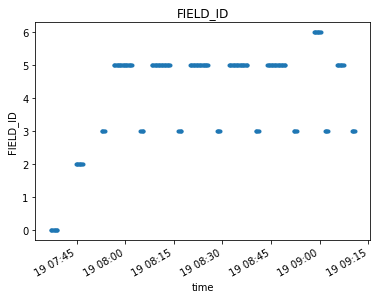

In [13]:
from cngi.dio import read_vis
from cngi.vis import visplot

# open a visibility xds
xds = read_vis('twhya.vis.zarr', 'xds0')

# fields versus time coordinate
visplot(xds.FIELD_ID, axis='time')

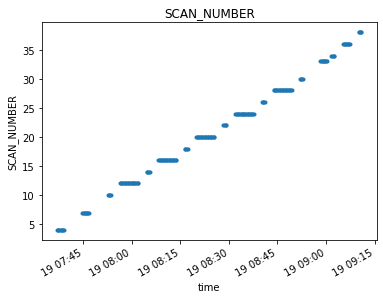

In [14]:
visplot(xds.SCAN_NUMBER, 'time')

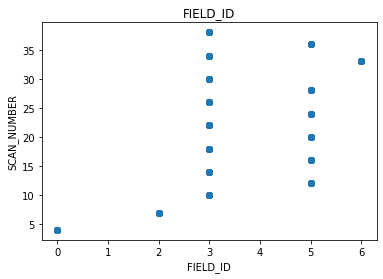

In [15]:
# 2-D plot - fields versus scans
visplot(xds.FIELD_ID, xds.SCAN_NUMBER)

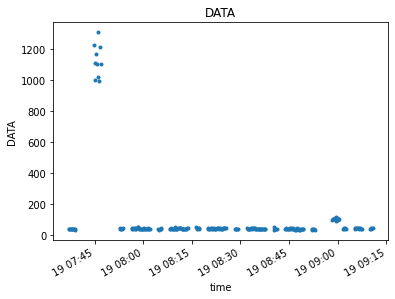

In [16]:
# 2-D plot of 4-D data - DATA over time
# when we specify an x-axis (time), the other axes (baseline, chan, pol) are averaged together
visplot(xds.DATA, axis='time')

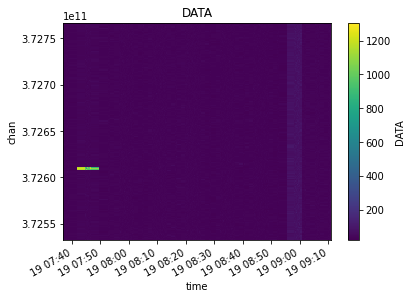

In [17]:
# 3-D plot of 4-D data - DATA over time and channel
# we can give two axes to create a color mesh visualization
visplot(xds.DATA, axis=['time','chan']) 

## Selection and Splitting

The xarray Dataset format has extensive built-in functions for selecting data and splitting by different criteria.  Often times the global data is referenced to identify particular values to select by.

Once the selection values are known, ```xds.isel(...)``` and ```xds.sel(...)``` can be used to select by dimension index or world value. ```xds.where(...)``` can be used to select by anything.  

Lets start by examining the range of time and channel frequency values we have available in the visibility xds along with the field names and state ids in the global data.

In [18]:
from cngi.dio import read_vis
import numpy as np

# open the master xds
mxds = read_vis('twhya.vis.zarr')

# inspect some properties
print('times: ', mxds.xds0.time.values[0], ' to ', mxds.xds0.time.values[-1])
print('chans: ', mxds.xds0.chan.values[0], ' to ', mxds.xds0.chan.values[-1])
print('fields: ', mxds.fields.values)

times:  2012-11-19T07:37:00.000000000  to  2012-11-19T09:11:01.631999969
chans:  372533086425.9812  to  372766851074.4187
fields:  ['J0522-364' 'J0539+145' 'Ceres' 'J1037-295' 'TW Hya' 'TW Hya' '3c279']


We can directly select specific dimension indices if we know what we're looking for

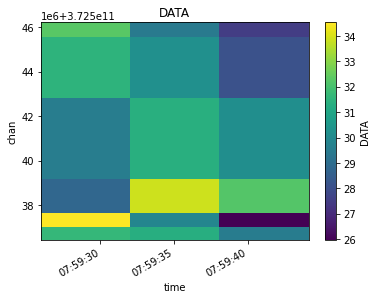

In [19]:
xds = mxds.xds0.isel(time=[76,77,78], chan=[6,7,8,12,20,21])

visplot(xds.DATA, ['time', 'chan'])

Or select by a range of dimension values, in this case lets select data between 372.59 and 372.63 GHz

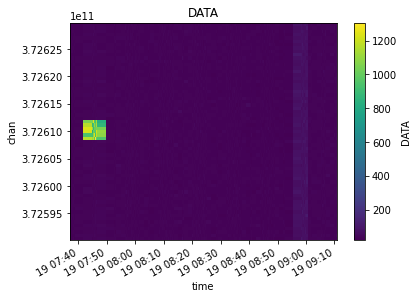

In [20]:
xds = mxds.xds0.sel(chan=slice(372.59e9, 372.63e9))

visplot(xds.DATA, ['time', 'chan'])

Or select by a particular field value, in this case lets select just the TW Hya fields

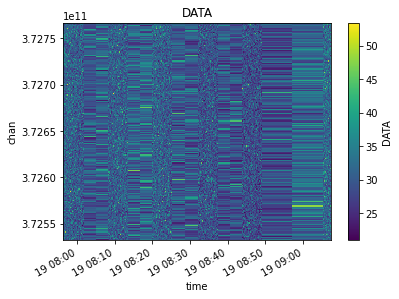

In [21]:
fields = mxds.field_ids[np.where(mxds.fields == 'TW Hya')].values

xds = mxds.xds0.where(mxds.xds0.FIELD_ID.isin(fields), drop=True)

visplot(xds.DATA, axis=['time','chan']) 

Finally, lets do a more complicated multi-selection

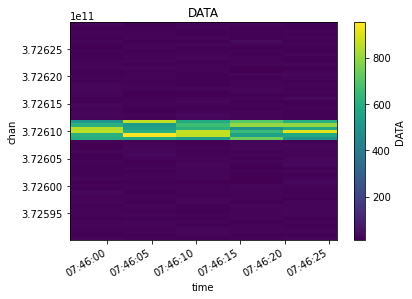

In [22]:
xds = mxds.xds0.where(mxds.xds0.ANTENNA1.isin([2,3,4,5]) & mxds.xds0.ANTENNA2.isin([2,3,4,5]) &
                       (mxds.xds0.chan > 372.59e9) & (mxds.xds0.chan < 372.63e9) & 
                       (mxds.xds0.time > np.datetime64('2012-11-19T07:45:50.0')) & 
                       (mxds.xds0.time < np.datetime64('2012-11-19T07:46:30.0')), 
                       drop=True)

visplot(xds.DATA, ['time', 'chan'])

Rather than cluttering each CNGI function with many parameters for data selection, instead the Dataset should be appropriately split before calling the relevant CNGI API function(s).


## Flagging

Any boolean data variable can be used to flag any other data variable of common dimension(s).

Flagged values are set to np.nan, and subsequent math/analysis should be of the type that ignores nan values.

First lets see the original raw data

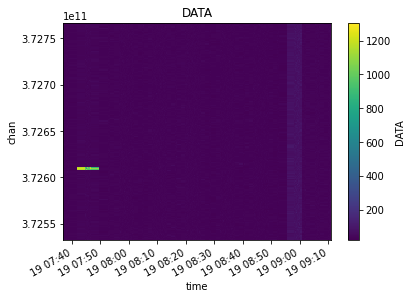

In [23]:
from cngi.dio import read_vis

xds = read_vis('twhya.vis.zarr', 'xds0')

visplot(xds.DATA, ['time', 'chan'])

Now lets flag the entire dataset contents based on the value of the FLAG data variable.  The bright line from Ceres is replaced with Nan's (that appear as blank whitespace in the plot)

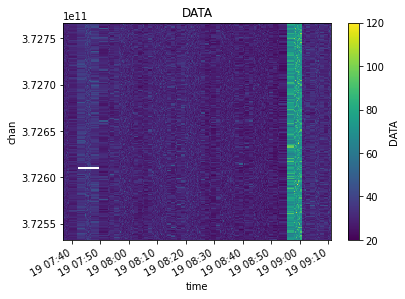

In [24]:
from cngi.vis import applyflags

flagged_xds = applyflags(xds, flags='FLAG')

visplot(flagged_xds.DATA, ['time', 'chan'])

## Averaging and Smoothing
Averaging functions will change the shape of the resulting xarray dataset along the dimension being averaged.  

Smoothing functions always return an xarray dataset with the same dimensions as the original.

We will use the TWHya dataset for this section. Dask may emit performance warnings if the chunk size is too small. We can increase our chunk size in the xds to any multiple of the chunk size used during conversion. We will do that here to avoid the performance warnings for this section. Note that baseline is already chunked at the maximum for its dimension size, so we can omit it.

In [25]:
from cngi.dio import read_vis

xds = read_vis('twhya.vis.zarr', 'xds0').chunk({'time':200, 'chan':64, 'pol':2})

### Channel Averaging

The channel averaging function looks for all data variables in the dataset with a channel dimension and averages by the specified bin width.  The returned dataset will have a different channel dimension size.

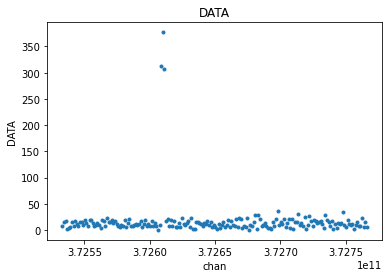

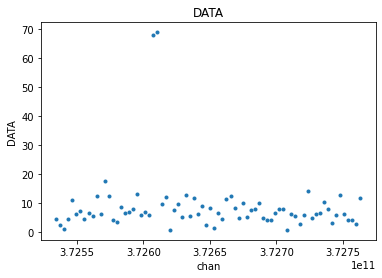

In [26]:
from cngi.vis import chanaverage, visplot

# average 5 channels of original unflagged data
avg_xds = chanaverage(xds, width=5)

# compare the original to the channel averaged
visplot(xds.DATA[30,0,:,0], 'chan')
visplot(avg_xds.DATA[30,0,:,0], 'chan')

In [27]:
# confirm new channel dimension after averaging
print(dict(xds.dims))
print(dict(avg_xds.dims))

{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 76, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}


Since every variable with a channel dimension in the dataset is averaged, this will also include the FLAG variable.  FLAG is a boolean type with values of 0 or 1 that are averaged over the width, resulting in a decimal number.  The result is then typcast back to boolean, which is the same as just rounding up.

Long story short, if any channel in the width is flagged, the resulting averaged channel will also be flagged

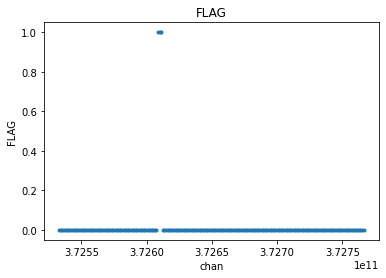

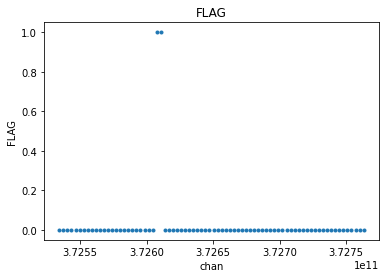

In [28]:
# compare the original flags to the channel averaged flags
visplot(xds.FLAG[30,0,:,0], 'chan')
visplot(avg_xds.FLAG[30,0,:,0], 'chan')

One might want to apply flags before channel averaging

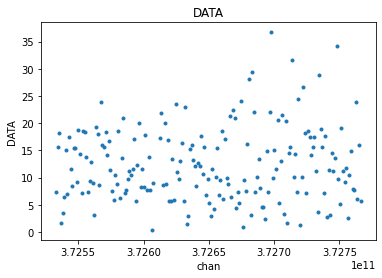

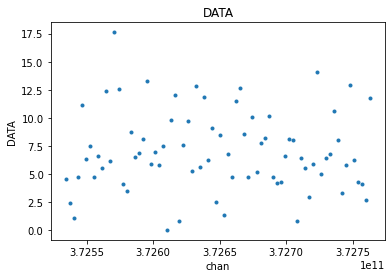

In [29]:
from cngi.vis import applyflags

flg_xds = applyflags(xds, flags=['FLAG'])
avg_flg_xds = chanaverage(flg_xds, width=5)

visplot(flg_xds.DATA[30,0,:,0], 'chan')
visplot(avg_flg_xds.DATA[30,0,:,0], 'chan')

Or apply flags after channel averaging

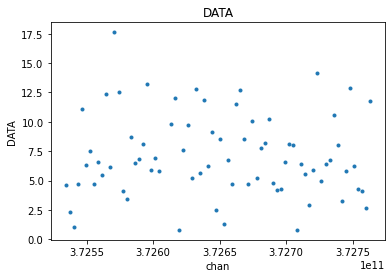

In [30]:
flg_avg_xds = applyflags(avg_xds, flags=['FLAG'])

visplot(flg_avg_xds.DATA[30,0,:,0], 'chan')

There is a small difference of two points, made more clear when we overlay the plots

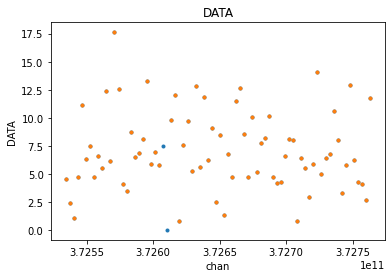

In [31]:
visplot(avg_flg_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(flg_avg_xds.DATA[30,0,:,0], 'chan', overplot=True)

### Time Averaging

The time averaging function can combine adjacent time steps or resample to a new uniform time step. This affects all fields in the xds that have a time dimension. The span parameter can be used to limit averaging to just the time steps within each scan, or within each state. The returned dataset will have a different time dimension size.

First let's average across the states in a scan using a bin of 7

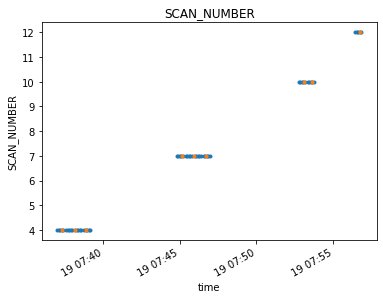

In [32]:
from cngi.vis import timeaverage

state_xds = timeaverage(xds, bin=7, span='state')

visplot(xds.SCAN_NUMBER.where(xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(state_xds.SCAN_NUMBER.where(state_xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

Averaging across both state and scan allows the bins to cross the time gaps between scans.

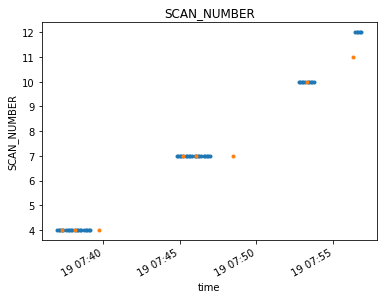

In [33]:
both_xds = timeaverage(xds, bin=7, span='both')

visplot(xds.SCAN_NUMBER.where(xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(both_xds.SCAN_NUMBER.where(both_xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

Switching to the width parameter will resample the contents of the xds to a uniform time bin across the span

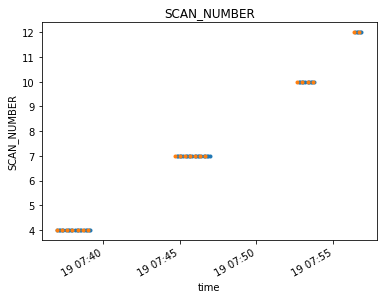

In [34]:
resampled_xds = timeaverage(xds, width='20s', span='state')

visplot(xds.SCAN_NUMBER.where(xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', drawplot=False)
visplot(resampled_xds.SCAN_NUMBER.where(resampled_xds.time < np.datetime64('2012-11-19T07:57:00.0'), drop=True), 'time', overplot=True)

In all cases, the dimensionality of the time averaged xds returned will be different than the start.

In [35]:
print(dict(xds.dims))
print(dict(state_xds.dims))
print(dict(both_xds.dims))
print(dict(resampled_xds.dims))

{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 410, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 68, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 59, 'uvw_index': 3}
{'baseline': 210, 'chan': 384, 'pol': 2, 'pol_id': 1, 'spw_id': 1, 'time': 150, 'uvw_index': 3}


We can inspect the affect of different time averaging methods on the DATA contents

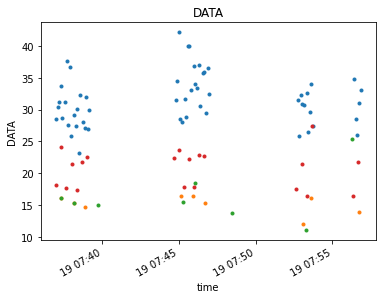

In [36]:
timefilter = np.datetime64('2012-11-19T07:57:00.0')
visplot(xds.DATA.where(xds.time < timefilter, drop=True)[:,:,100,0], 'time', drawplot=False)
visplot(state_xds.DATA.where(state_xds.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True, drawplot=False)
visplot(both_xds.DATA.where(both_xds.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True, drawplot=False)
visplot(resampled_xds.DATA.where(resampled_xds.time < timefilter, drop=True)[:,:,100,0], 'time', overplot=True)

Flagging works the same way as in channel averaging.  Flags are averaged with all other data sharing the time axis.  They may be applied before or after time averaging. The time averaged flag field is converted back to boolean.  Any single flagged value in the original data will cause the entire bin to be flagged in the resulting data.

### Channel Smoothing

Channel smoothing allows a variety of window shapes to be convolved across the channel dimension to smooth over changes from bin to bin. The standard CASA hanning smooth is supported as the default option.  The returned dataset will have the same dimensions as the original.

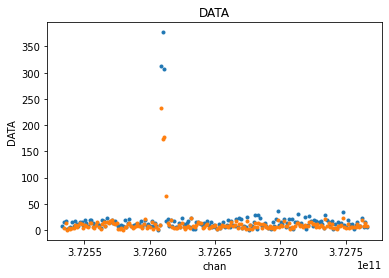

In [37]:
from cngi.vis import chansmooth

smooth_xds = chansmooth(xds)

visplot(xds.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(smooth_xds.DATA[30,0,:,0], 'chan', overplot=True)

chansmooth uses the scipy.signal package to set the window shape. Therefore, all the window functions supported by scipy are also supported here.  The size of the window width is configurable.

[https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)


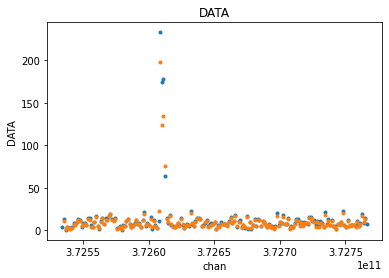

In [38]:
bohman_xds = chansmooth(xds, type='bohman', size=7)

visplot(smooth_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(bohman_xds.DATA[30,0,:,0], 'chan', overplot=True)

non-unity gains are also supported to amplify or attenuate the output

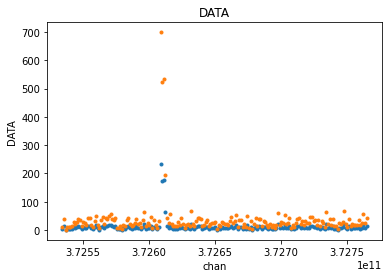

In [39]:
hann_xds = chansmooth(xds, type='hann', size=5, gain=1.0)
amp_hann_xds = chansmooth(xds, type='hann', size=5, gain=3.0)

visplot(hann_xds.DATA[30,0,:,0], 'chan', drawplot=False)
visplot(amp_hann_xds.DATA[30,0,:,0], 'chan', overplot=True)

## UV Fitting

Various modeling can be performed in the UV-domain through polynomial regression on the visibility data.

The uvcontfit function takes a source data variable in the xarray dataset and fits a polynomial of fitorder across the channel axis.  The resulting model is placed in the target data variable and retains the dimensionality of the source. Specified channels may be excluded to focus on fitting only continuum visibilities and not line emissions.

In our example dataset we know that the Ceres has a line emission, so let's focus on just that field.  We will need to master xarray dataset to see which field ID(s) is Ceres.

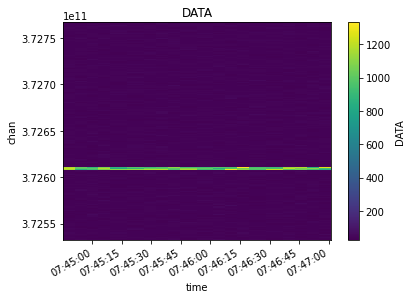

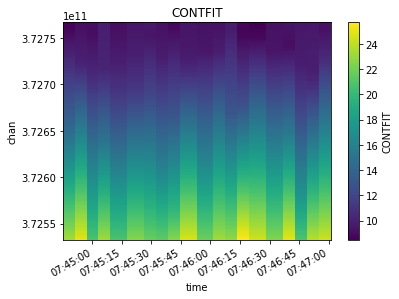

In [40]:
from cngi.dio import read_vis
from cngi.vis import uvcontfit, visplot
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

mxds = read_vis('twhya.vis.zarr')

fields = mxds.field_ids[np.where(mxds.fields == 'Ceres')].values

ceres_xds = mxds.xds0.where(mxds.xds0.FIELD_ID.isin(fields), drop=True)

fit_xds = uvcontfit(ceres_xds, source='DATA', target='CONTFIT')

visplot(fit_xds.DATA, ['time', 'chan'])
visplot(fit_xds.CONTFIT, ['time', 'chan'])

What we are seeing is merged across baselines and polarizations.  Let's look at just one time/baseline/pol sample and examine the fit.  The linear fit is skewed by the line emission towards one side of the channel axis.


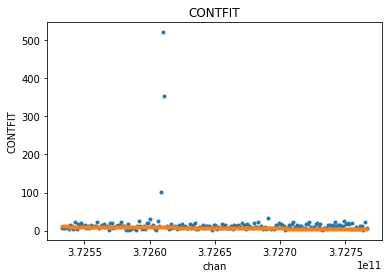

In [41]:
visplot(fit_xds.DATA[10,10,:,0], ['chan'], drawplot=False)
visplot(fit_xds.CONTFIT[10,10,:,0], ['chan'], overplot=True)

Let's omit the channels with the line emission and do the fit again.  We should see less skewing in the fitted continuum.

The fits appear lower in value than the mean of the data when viewing the magnitude of complex visibilities. The real and imaginary parts are fitted individually. We examine just the real piece here to see a that the fit is indeed a decent approximation through the center of the data.

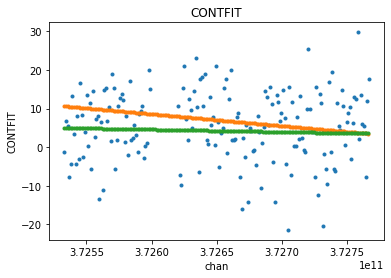

In [42]:
excludechans = np.where( (mxds.xds0.chan > 3.726e11) & (mxds.xds0.chan < 3.7262e11) )[0]

fit_xds2 = uvcontfit(ceres_xds, source='DATA', target='CONTFIT', fitorder=1, excludechans=excludechans)

includechans = np.setdiff1d( range(mxds.xds0.dims['chan']), excludechans)
visplot(fit_xds2.DATA[10,10,includechans,0].real, ['chan'], drawplot=False)
visplot(fit_xds.CONTFIT[10,10,:,0].real, ['chan'], drawplot=False, overplot=True)
visplot(fit_xds2.CONTFIT[10,10,:,0].real, ['chan'], overplot=True)

For even more fun, we can try a higher order fit. Let's use all channels to allow the line emission to exaggerate the non-linearity, but only plot the continuum DATA channels so the y-scale stays smaller.

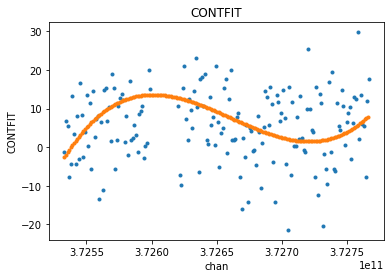

In [43]:
fit_xds3 = uvcontfit(ceres_xds, source='DATA', target='CONTFIT', fitorder=3, excludechans=[])

visplot(fit_xds3.DATA[10,10,includechans,0].real, ['chan'], drawplot=False)
visplot(fit_xds3.CONTFIT[10,10,:,0].real, ['chan'], overplot=True)

Several metrics related to the quality of the fit are stored in the xarray dataset attributes section as metadata.  They are named with a prefix matching the target parameter in uvcontfit.

In [44]:
metrics = [kk for kk in fit_xds.attrs.keys() if kk.startswith('CONTFIT')]
print(metrics)

print(fit_xds.CONTFIT_rms_error)

['CONTFIT_rms_error', 'CONTFIT_min_max_error', 'CONTFIT_bw_frac', 'CONTFIT_freq_frac']
<xarray.DataArray ()>
dask.array<pow, shape=(), dtype=complex128, chunksize=(), chunktype=numpy.ndarray>


One thing to note is that these metrics are dask elements, and are not actually computed until explicity requested. Things like visplot explicity force the computation of the data needed for plotting, but nothing has forced these metrics to be computed yet. So we will call .compute() to see their values.

In [45]:
print('rms error with line included: ', fit_xds.CONTFIT_rms_error.values)
print('rms error with line excluded: ', fit_xds2.CONTFIT_rms_error.values)

rms error with line included:  (16.444908051664182-0.7566763926282181j)
rms error with line excluded:  (0.37306136672597817-0.007993456030923675j)
